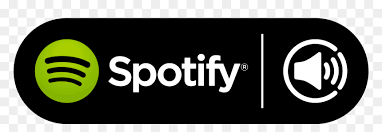

Our choice of dataset is the **Spotify Dataset** 1921-2020, 160k+ Tracks dataset from Kaggle. In our project we will be attempting to predict the popularity of a song in the Spotify dataset based upon other features in the dataset. Some of the features we plan on using as predictors are acousticness, danceability, energy, instrumentalness, energy, liveness, loudness, speechiness, tempo, and valence.

**Info on popularity score**
(according to Spotify for Developers - [Documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-tracks/) / https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-tracks/)
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

**Team Members:**



*   *Marianna Petrovich*
*   *Bijan Pourazari*
*   *Christian Salas*
*   *Michael Garber*


Importing packages we need


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

Reading the data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/BowieRules/cst383/master/data.csv")

Exploring the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

In [ ]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [ ]:
df.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,1.743890e+05,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.499228,0.536758,2.328100e+05,0.482721,0.068135,0.197252,5.205305,0.211123,-11.750865,0.702384,25.693381,0.105729,117.006500,0.524533,1977.061764
std,0.379936,0.176025,1.483958e+05,0.272685,0.251978,0.334574,3.518292,0.180493,5.691591,0.457211,21.872740,0.182260,30.254178,0.264477,26.907950
min,0.000000,0.000000,4.937000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.087700,0.414000,1.661330e+05,0.249000,0.000000,0.000000,2.000000,0.099200,-14.908000,0.000000,1.000000,0.035200,93.931000,0.311000,1955.000000
50%,0.517000,0.548000,2.057870e+05,0.465000,0.000000,0.000524,5.000000,0.138000,-10.836000,1.000000,25.000000,0.045500,115.816000,0.536000,1977.000000
75%,0.895000,0.669000,2.657200e+05,0.711000,0.000000,0.252000,8.000000,0.270000,-7.499000,1.000000,42.000000,0.076300,135.011000,0.743000,1999.000000
max,0.996000,0.988000,5.338302e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.971000,243.507000,1.000000,2021.000000


**Data Cleaning** is not required, no NANs present

In [ ]:
df.isna().sum().sum()

0

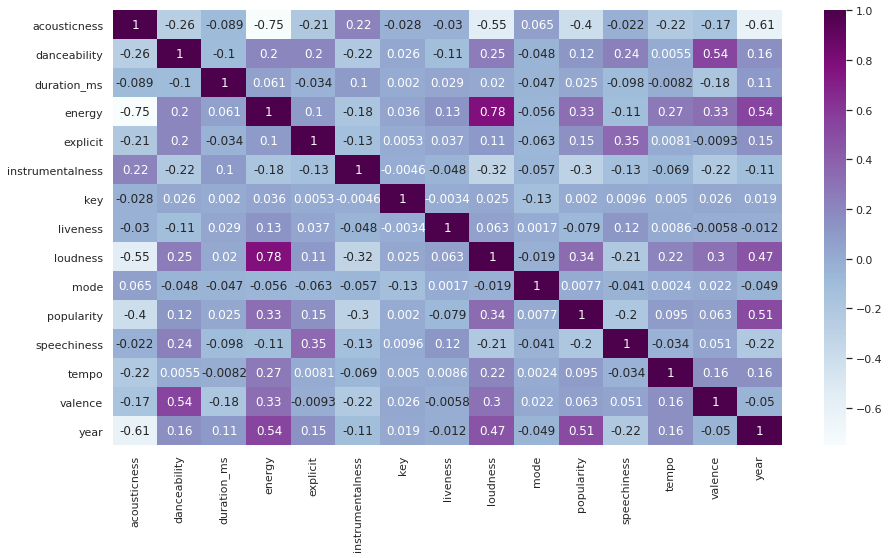

In [ ]:
plt.figure(figsize=(15, 8))
sns.set(style="dark")
corr = df.corr()
sns.heatmap(corr,annot=True,cmap="BuPu")

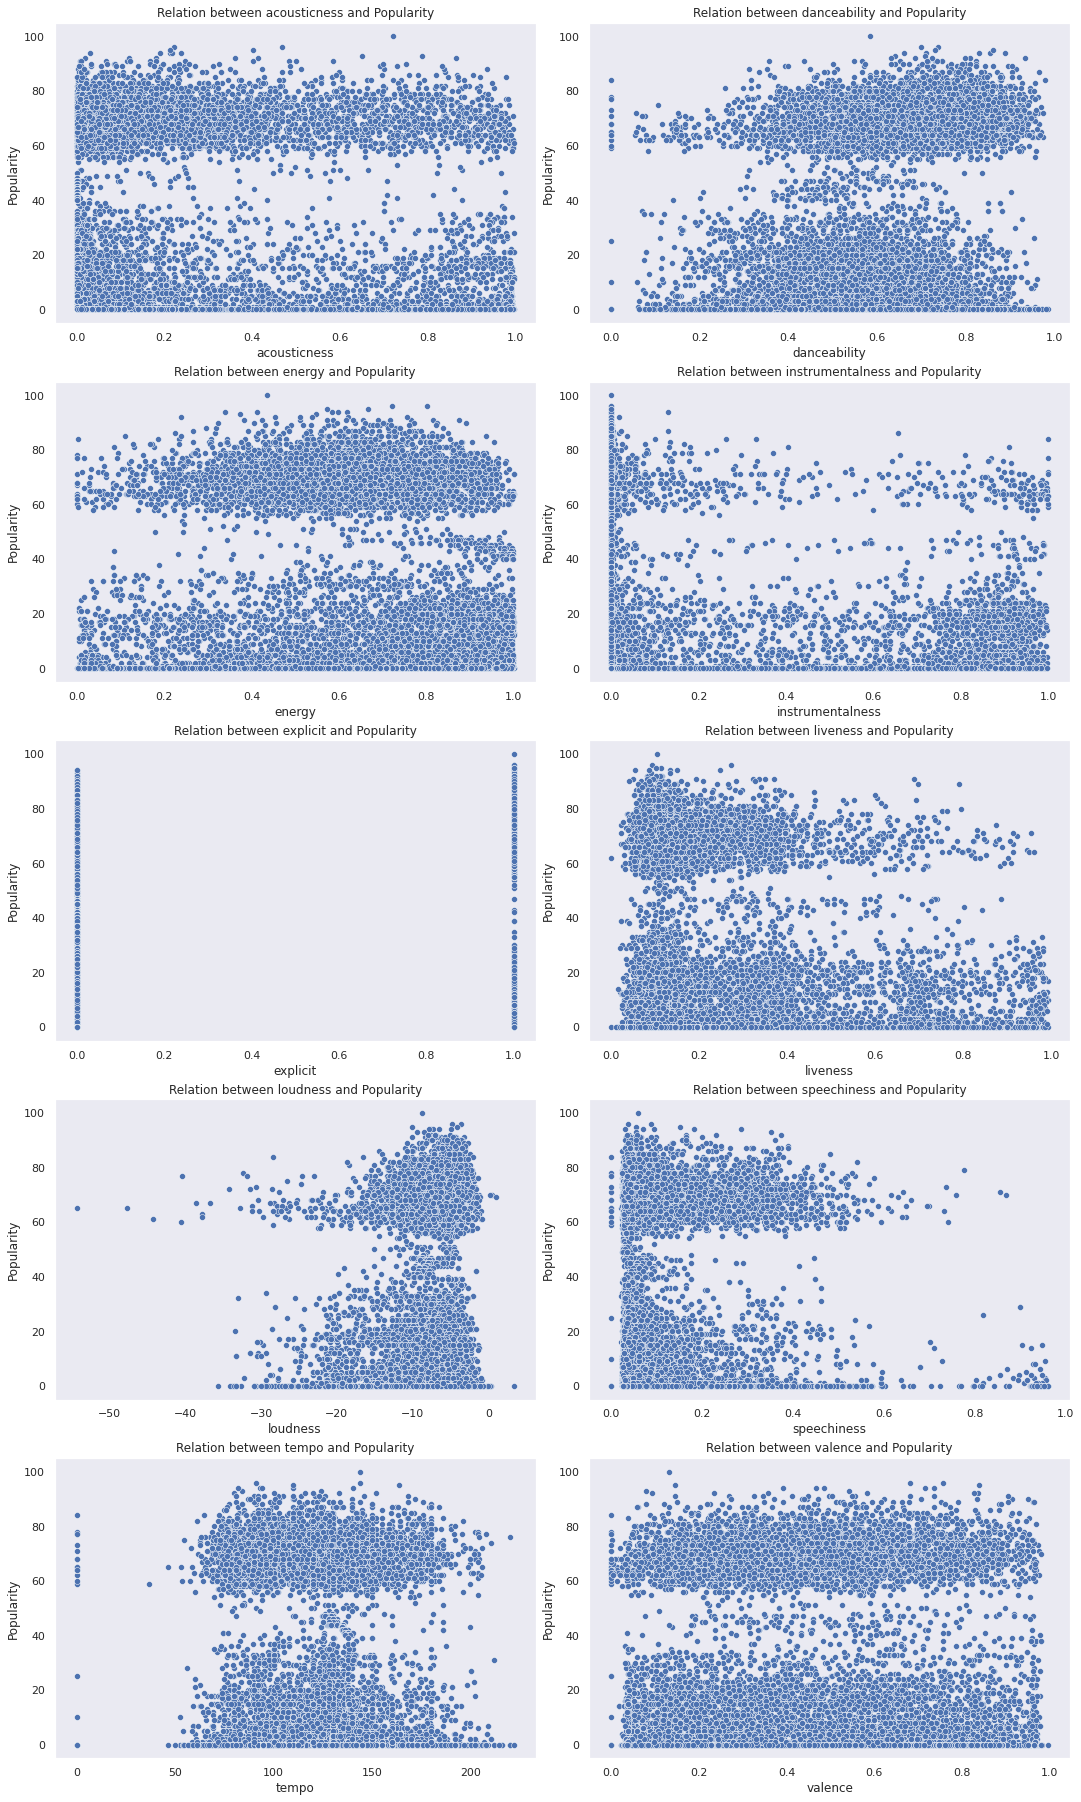

In [ ]:
subset = df[df['year'] >= 2016]
variables = ['acousticness', 'danceability', 'energy','instrumentalness', 'explicit', 'liveness',
             'loudness', 'speechiness', 'tempo', 'valence']
year = range(2016,2021)

fig = plt.figure(figsize=(15,25))
for variable,num in zip(variables, range(1,len(variables)+1)):
    ax = fig.add_subplot(5,2,num)
    sns.scatterplot(x = variable, y = 'popularity', data=subset)
    plt.title('Relation between {} and Popularity'.format(variable))
    plt.xlabel(variable)
    plt.ylabel('Popularity')
fig.tight_layout(pad=0.5)

In [ ]:
predictors = ['loudness','energy','danceability']
X = df[predictors].values
target = 'popularity'
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regr = KNeighborsRegressor()
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)